在沙盒环境，期货交易策略及拦截模型择时优化

In [1]:
import os, copy, sys, datetime
os.environ['ULTRON_DATA'] = 'keim'
os.environ['IGNORE_WARNINGS'] = '0'
import numpy as np
import pandas as pd

In [2]:
from ultron.env import *
from ultron.ump.core import env
from ultron.ump.indicator.atr import atr14, atr21
from ultron.ump.market.symbol_pd import _benchmark
from ultron.ump.metrics.metrics_base import MetricsBase
from ultron.ump.factor import FactorPreAtrNStop, FactorAtrNStop, FactorCloseAtrNStop, \
    FactorBuyBreak, FactorBuyPutBreak
from ultron.ump.core.ump import run_loop_back
from ultron.kdutils.parallel import delayed, Parallel
from ultron.kdutils.progress import MulPidProgress
from matplotlib import pyplot as plt
import seaborn as sns

/var/log/ultron/2022-10-10.log


In [3]:
from ultron.ump.ump.main_deg import MainDeg
from ultron.ump.ump.main_price import MainPrice
from ultron.ump.ump.main_wave import MainWave
from ultron.ump.ump.main_full import MainFull
from ultron.ump.ump.main_mul import MainMul

In [4]:
from ultron.ump.ump.edge_deg import EdgeDeg
from ultron.ump.ump.edeg_price import EdgePrice
from ultron.ump.ump.edge_wave import EdgeWave
from ultron.ump.ump.edge_full import EdgeFull
from ultron.ump.ump.edge_mul import EdgeMul

In [5]:
os.environ['UMP_MODEL_PATH'] = g_project_data

#### 加载行情数据

In [6]:
def prev_returs_impl(price_data, key, name):
    price_tb = price_data[key].unstack()
    price_tb.fillna(method='pad', inplace=True)
    return_tb = np.log(price_tb / price_tb.shift(1))
    return_tb = return_tb.replace([np.inf, -np.inf], np.nan)
    return_tb = return_tb.stack().reindex(price_data.index)
    return_tb.name = name
    return return_tb

In [7]:
def pre_close_impl(price_data, key, name):
    price_tb = price_data[key].unstack()
    price_tb.fillna(method='pad', inplace=True)
    return_tb = price_tb.shift(-1)
    return_tb = return_tb.stack().reindex(price_data.index)
    return_tb.name = name
    return return_tb

In [8]:
market_data = pd.read_csv(os.path.join(g_project_data, 'market_data.csv'), index_col=0)
market_data['trade_date'] = pd.to_datetime(market_data['trade_date'])

prev_rets = prev_returs_impl(
    market_data.set_index(['trade_date','code']),'closePrice','pre1_ret').reset_index()
prev_rets['trade_date'] = pd.to_datetime(prev_rets['trade_date'])


pre_close = pre_close_impl(
    market_data.set_index(['trade_date','code']),'closePrice','pre_close').reset_index()
pre_close['trade_date'] = pd.to_datetime(pre_close['trade_date'])


market_data = market_data.merge(prev_rets, on=['trade_date','code']).merge(
    pre_close, on=['trade_date','code'])
market_data.tail()

,trade_date,code,openPrice,highestPrice,lowestPrice,closePrice,turnoverVol,pre1_ret,pre_close
37248,2022-06-22,TA,6924.0,6982.0,6746.0,6762.0,1704954,-0.0205,NaN
37249,2022-06-22,V,7650.0,7707.0,7352.0,7381.0,918970,-0.0358,NaN
37250,2022-06-22,Y,10836.0,10864.0,10342.0,10372.0,844983,-0.0410,NaN
37251,2022-06-22,ZC,850.0,889.0,833.4,844.2,70,0.0002,NaN
37252,2022-06-22,ZN,25570.0,25860.0,25280.0,25295.0,160696,-0.0028,NaN


In [9]:
env.g_market_target = env.EMarketTargetType.E_MARKET_TARGET_FUTURES_CN
env.g_enable_ml_feature = True
market_trade_year = 252
n_fold = 2

In [10]:
# 初始化资金500万
read_cash = 5000000

# 买入因子依然延用向上突破因子
buy_factors = [{'xd': 60, 'class': FactorBuyBreak},
               {'xd': 42, 'class': FactorBuyBreak},
               {'xd': 42, 'class': FactorBuyPutBreak},
               {'xd': 60, 'class': FactorBuyPutBreak}]

sell_factors = [
    {'stop_loss_n': 1.0, 'stop_win_n': 3.0,
     'class': FactorAtrNStop},
    {'class': FactorPreAtrNStop, 'pre_atr_n': 1.5},
    {'class': FactorCloseAtrNStop, 'close_atr_n': 1.5}
]

In [11]:
def calc_atr(kline_df):
    kline_df['atr21'] = 0
    if kline_df.shape[0] > 21:
        # 大于21d计算atr21
        kline_df['atr21'] = atr21(kline_df['high'].values,
                                  kline_df['low'].values,
                                  kline_df['pre_close'].values)
        # 将前面的bfill
        kline_df['atr21'].fillna(method='bfill', inplace=True)
    kline_df['atr14'] = 0
    if kline_df.shape[0] > 14:
        # 大于14d计算atr14
        kline_df['atr14'] = atr14(kline_df['high'].values,
                                  kline_df['low'].values,
                                  kline_df['pre_close'].values)
        # 将前面的bfill
        kline_df['atr14'].fillna(method='bfill', inplace=True)

In [12]:
pick_kl_pd_dict = {}

In [13]:
market_data['date'] = pd.to_datetime(
    market_data['trade_date']).dt.strftime('%Y%m%d').astype(int)
market_data['date_week'] = market_data['date'].apply(
    lambda x: datetime.datetime.strptime(str(x), '%Y%m%d').weekday())
market_data['trade_date'] = pd.to_datetime(market_data['trade_date'])

indicator_data = market_data.rename(
    columns={
        'pre_close': 'pre_close',
        'openPrice': 'open',
        'closePrice': 'close',
        'highestPrice': 'high',
        'lowestPrice': 'low',
        'turnoverVol': 'volume',
        'pre1_ret':'p_change'
    }).set_index(['trade_date'])
indicator_data['p_change'] = indicator_data['p_change'] * 100

code = 'SA'
benchmark_kl_pd = indicator_data.reset_index().set_index(
    'code').loc[code].reset_index().set_index('trade_date')
benchmark_kl_pd['key'] = list(range(0, len(benchmark_kl_pd)))
benchmark_kl_pd.index = pd.to_datetime(benchmark_kl_pd.index)
calc_atr(benchmark_kl_pd)
ind = benchmark_kl_pd.key.values[-1] - market_trade_year * n_fold + 1
start_date = benchmark_kl_pd.index[ind]
benchmark_kl_pd = benchmark_kl_pd.loc[start_date:]
benchmark_kl_pd.name = str(code) + '0'




pick_kl_pd_dict = {}
#['RB','I','JM','MA','TA']
choice_symbols = [code for code in market_data['code'].unique().tolist() if code not in ['SA','LH']][0:10]
for code in choice_symbols:
    kl_pd = indicator_data.reset_index().set_index(
        'code').loc[code].reset_index().set_index('trade_date')
    kl_pd.index = pd.to_datetime(kl_pd.index)
    kl_pd.name = str(code) + '0'
    kl_pd = _benchmark(kl_pd, benchmark_kl_pd)
    calc_atr(kl_pd)
    kl_pd['key'] = list(range(0, len(kl_pd)))
    pick_kl_pd_dict[str(code) + '0'] = kl_pd

choice_symbols = [str(code) + '0' for code in choice_symbols]

In [14]:
len(choice_symbols)

10

In [15]:
result_tuple, kl_pd_manager = run_loop_back(read_cash=read_cash, buy_factors=buy_factors,
              sell_factors=sell_factors, 
              benchmark_kl_pd=benchmark_kl_pd,
              pick_kl_pd_dict=pick_kl_pd_dict,
              choice_symbols=choice_symbols)

Box(children=(Text(value='pid=10245 begin work'), FloatProgress(value=0.0)))

In [16]:
metrics = MetricsBase.show_general(result_tuple.orders_pd, result_tuple.action_pd,
                                        result_tuple.capital, result_tuple.benchmark)

In [17]:
## 考虑资金情况下的度量，进行与benchmark的收益度量对比
print('买入后卖出的交易数量:{}'.format(metrics.order_has_ret.shape[0]))
print('买入后尚未卖出的交易数量:{}'.format(metrics.order_keep.shape[0]))
#print('胜率:{:.4f}%'.format(metrics.win_rate * 100))
print('平均获利期望:{:.4f}%'.format(metrics.gains_mean * 100))
#print('平均亏损期望:{:.4f}%'.format(metrics.losses_mean * 100))
#print('盈亏比:{:.4f}'.format(metrics.win_loss_profit_rate))
print('策略收益: {:.4f}%'.format(metrics.algorithm_period_returns *
                                             100))
print('基准收益: {:.4f}%'.format(metrics.benchmark_period_returns *
                                             100))
print('策略年化收益: {:.4f}%'.format(
            metrics.algorithm_annualized_returns * 100))
print('基准年化收益: {:.4f}%'.format(
            metrics.benchmark_annualized_returns * 100))
print('策略买入成交比例:{:.4f}%'.format(metrics.buy_deal_rate * 100))
print('策略资金利用率比例:{:.4f}%'.format(metrics.cash_utilization * 100))
print('策略共执行{}个交易日'.format(metrics.num_trading_days))

买入后卖出的交易数量:175
买入后尚未卖出的交易数量:6
平均获利期望:4.3141%
策略收益: 10.7490%
基准收益: 22.5363%
策略年化收益: 5.3318%
基准年化收益: 11.1787%
策略买入成交比例:71.8232%
策略资金利用率比例:53.3941%
策略共执行504个交易日


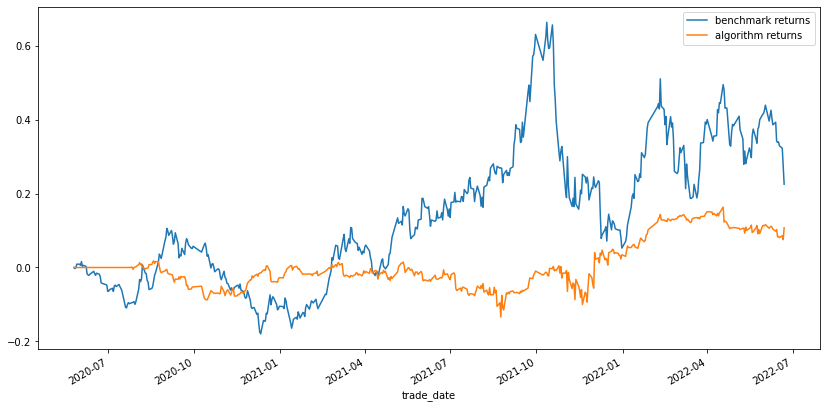

In [18]:
plt.figure(figsize=(14, 7))
metrics.benchmark_cum_returns.plot()
metrics.algorithm_cum_returns.plot()
plt.legend(['benchmark returns', 'algorithm returns'], loc='best')
plt.show()

### 裁决模型训练

In [19]:
ump_deg=None
ump_mul=None
ump_price=None
ump_wave=None

In [20]:
orders_pd_train_cn = result_tuple.orders_pd

def train_main_ump():
    print('UmpMainDeg begin...')
    MainDeg.ump_main_clf_dump(orders_pd_train_cn)
    print('UmpMainPrice begin...')
    MainPrice.ump_main_clf_dump(orders_pd_train_cn)
    print('UmpMainMul begin...')
    MainMul.ump_main_clf_dump(orders_pd_train_cn)
    print('MainWave begin...')
    MainWave.ump_main_clf_dump(orders_pd_train_cn)
    # 依然使用load_main_ump，避免下面多进程内存拷贝过大
    load_main_ump()
    
def load_main_ump():
    global ump_deg, ump_mul, ump_price, ump_wave
    ump_deg = MainDeg(predict=True)
    ump_mul = MainMul(predict=True)
    ump_price = MainPrice(predict=True)
    ump_wave = MainWave(predict=True)
    print('load main ump complete!')

In [21]:
%%time
train_main_ump()
#load_main_ump()

UmpMainDeg begin...
please wait! dump_pickle....: /home/kerry/ultron/rom/sandbox/keim/ump/ump_main_futures_cn_deg_main
UmpMainPrice begin...
please wait! dump_pickle....: /home/kerry/ultron/rom/sandbox/keim/ump/ump_main_futures_cn_price_main
UmpMainMul begin...
please wait! dump_pickle....: /home/kerry/ultron/rom/sandbox/keim/ump/ump_main_futures_cn_mul_main
MainWave begin...
please wait! dump_pickle....: /home/kerry/ultron/rom/sandbox/keim/ump/ump_main_futures_cn_wave_main
load main ump complete!
CPU times: user 14min 5s, sys: 23.7 s, total: 14min 28s
Wall time: 14min 48s


### 验证主裁是否称职

In [22]:
# 选取有交易结果的数据order_has_result
order_has_result = result_tuple.orders_pd[result_tuple.orders_pd.result != 0]

In [23]:
order_has_result.filter(regex='^buy(_deg_|_price_|_wave_|_jump)').head()

,buy_deg_ang42,buy_deg_ang252,buy_deg_ang60,buy_deg_ang21,buy_price_rank120,buy_price_rank90,buy_price_rank60,buy_price_rank252,buy_wave_score1,buy_wave_score2,buy_wave_score3,buy_jump_up_power,buy_jump_down_power
2020-07-27,3.568,3.568,3.568,3.539,1.0,1.0,1.0,1.0,1.194,1.144,1.125,0.0,0.000
2020-07-28,4.222,4.273,4.273,4.670,1.0,1.0,1.0,1.0,1.737,1.653,1.616,0.0,-1.307
2020-07-31,6.965,7.686,7.686,2.105,1.0,1.0,1.0,1.0,0.975,1.002,1.004,0.0,0.000
2020-08-03,4.862,5.429,5.429,2.734,1.0,1.0,1.0,1.0,0.322,0.335,0.343,0.0,0.000
2020-08-03,6.804,7.880,7.880,5.373,1.0,1.0,1.0,1.0,0.267,0.317,0.335,0.0,0.000


可以通过一个一个迭代交易单，将交易单中的买入时刻特征传递给ump主裁决策器，让每一个主裁来决策是否进行拦截，这样可以统计每一个主裁的拦截成功率，以及整体拦截率等，如下所示：

In [24]:
def apply_ml_features_ump(order, predicter, progress, need_hit_cnt):
    if not isinstance(order.ml_features, dict):
        import ast
        # 低版本pandas dict对象取出来会成为str
        ml_features = ast.literal_eval(order.ml_features)
    else:
        ml_features = order.ml_features
    progress.show()
    # 将交易单中的买入时刻特征传递给ump主裁决策器，让每一个主裁来决策是否进行拦截
    return predicter.predict_kwargs(need_hit_cnt=need_hit_cnt, **ml_features)

def pararllel_func(ump_object, ump_name):
    with MulPidProgress(len(order_has_result), '{} complete'.format(ump_name)) as progress:
        # 启动多进程进度条，对order_has_result进行apply
        ump_result = order_has_result.apply(apply_ml_features_ump, axis=1, args=(ump_object, progress, 2,))
    return ump_name, ump_result

out = []
for ump_object, ump_name in zip([ump_deg, ump_mul, ump_price, ump_wave], 
                                ['ump_deg', 'ump_mul', 'ump_price', 'ump_wave']):
    ump_name, ump_result = pararllel_func(ump_object, ump_name)
    out.append((ump_name, ump_result))
    
# 将每一个进程中的裁判的拦截决策进行汇总
for sub_out in out:
    order_has_result[sub_out[0]] = sub_out[1]

Box(children=(Text(value='pid=10245 begin work'), FloatProgress(value=0.0)))

please wait! load_pickle....: /home/kerry/ultron/rom/sandbox/keim/ump/ump_main_futures_cn_deg_main


Box(children=(Text(value='pid=10245 begin work'), FloatProgress(value=0.0)))

please wait! load_pickle....: /home/kerry/ultron/rom/sandbox/keim/ump/ump_main_futures_cn_mul_main


Box(children=(Text(value='pid=10245 begin work'), FloatProgress(value=0.0)))

please wait! load_pickle....: /home/kerry/ultron/rom/sandbox/keim/ump/ump_main_futures_cn_price_main


Box(children=(Text(value='pid=10245 begin work'), FloatProgress(value=0.0)))

please wait! load_pickle....: /home/kerry/ultron/rom/sandbox/keim/ump/ump_main_futures_cn_wave_main


In [25]:
block_pd = order_has_result.filter(regex='^ump_*')
# 把所有主裁的决策进行相加
block_pd['sum_bk'] = block_pd.sum(axis=1)
block_pd['result'] = order_has_result['result']
# 有投票1的即会进行拦截
block_pd = block_pd[block_pd.sum_bk > 0]
print('四个裁判整体拦截正确率{:.2f}%'.format(
    block_pd[block_pd.result == -1].result.count() / block_pd.result.count() * 100))
block_pd.tail()

四个裁判整体拦截正确率80.39%


,ump_deg,ump_mul,ump_price,ump_wave,sum_bk,result
2022-05-25,1,0,0,1,2,1
2022-06-06,1,1,1,1,4,-1
2022-06-06,1,1,1,1,4,-1
2022-06-10,1,1,1,1,4,-1
2022-06-16,0,0,0,1,1,1


下面统计每一个主裁的拦截正确率：

In [26]:
from sklearn import metrics
def sub_ump_show(block_name):
    sub_block_pd = block_pd[(block_pd[block_name] == 1)]
    # 如果失败就正确 －1->1 1->0
    sub_block_pd.result = np.where(sub_block_pd.result == -1, 1, 0)
    return metrics.accuracy_score(sub_block_pd[block_name], sub_block_pd.result) * 100, sub_block_pd.result.count()

print('角度裁判拦截正确率{:.2f}%, 拦截交易数量{}'.format(*sub_ump_show('ump_deg')))
print('波动裁判拦拦截正确率{:.2f}%, 拦截交易数量{}'.format(*sub_ump_show('ump_wave')))
print('单混裁判拦截正确率{:.2f}%, 拦截交易数量{}'.format(*sub_ump_show('ump_mul')))
print('价格裁判拦截正确率{:.2f}%, 拦截交易数量{}'.format(*sub_ump_show('ump_price')))

角度裁判拦截正确率86.67%, 拦截交易数量75
波动裁判拦拦截正确率86.57%, 拦截交易数量67
单混裁判拦截正确率91.30%, 拦截交易数量69
价格裁判拦截正确率100.00%, 拦截交易数量45


### 验证边裁是否称职

In [27]:
print('EdgeDeg begin...')
EdgeDeg.ump_edge_clf_dump(orders_pd_train_cn)
edge_deg = EdgeDeg(predict=True)

print('EdgePrice begin...')
EdgePrice.ump_edge_clf_dump(orders_pd_train_cn)
edge_price = EdgePrice(predict=True)

print('EdgeMul begin...')
EdgeMul.ump_edge_clf_dump(orders_pd_train_cn)
edge_mul = EdgeMul(predict=True)

print('EdgeWave begin...')
EdgeWave.ump_edge_clf_dump(orders_pd_train_cn)
edge_wave = EdgeWave(predict=True)

print('EdgeFull begin...')
EdgeFull.ump_edge_clf_dump(orders_pd_train_cn)
edge_full = EdgeFull(predict=True)

print('fit edge complete!')

EdgeDeg begin...
please wait! dump_pickle....: /home/kerry/ultron/rom/sandbox/keim/ump/ump_edge_futures_cn_deg_edge
EdgePrice begin...
please wait! dump_pickle....: /home/kerry/ultron/rom/sandbox/keim/ump/ump_edge_futures_cn_price_edge
EdgeMul begin...
please wait! dump_pickle....: /home/kerry/ultron/rom/sandbox/keim/ump/ump_edge_futures_cn_mul_edge
EdgeWave begin...
please wait! dump_pickle....: /home/kerry/ultron/rom/sandbox/keim/ump/ump_edge_futures_cn_wave_edge
EdgeFull begin...
please wait! dump_pickle....: /home/kerry/ultron/rom/sandbox/keim/ump/ump_edge_futures_cn_full_edge
fit edge complete!


### 验证边裁是否称职

In [28]:
def apply_ml_features_edge(order, predicter, progress):
    if not isinstance(order.ml_features, dict):
        import ast
        # 低版本pandas dict对象取出来会成为str
        ml_features = ast.literal_eval(order.ml_features)
    else:
        ml_features = order.ml_features
    # 边裁进行裁决
    progress.show()
    # 将交易单中的买入时刻特征传递给ump边裁决策器，让每一个边裁来决策是否进行拦截
    edge = predicter.predict(**ml_features)
    return edge.value


def edge_pararllel_func(edge, edge_name):
    with MulPidProgress(len(order_has_result), '{} complete'.format(edge_name)) as progress:
        # # 启动多进程进度条，对order_has_result进行apply
        edge_result = order_has_result.apply(apply_ml_features_edge, axis=1, args=(edge, progress,))
    return edge_name, edge_result

for edge, edge_name in zip([edge_deg, edge_price, edge_mul, edge_wave], 
                        ['edge_deg', 'edge_price', 'edge_mul', 'edge_wave']):
    
    edge_name, edge_result = edge_pararllel_func(edge, edge_name)
    out.append((edge_name, edge_result))
    
# 将每一个进程中的裁判的拦截决策进行汇总
for sub_out in out:
    order_has_result[sub_out[0]] = sub_out[1]

Box(children=(Text(value='pid=10245 begin work'), FloatProgress(value=0.0)))

please wait! load_pickle....: /home/kerry/ultron/rom/sandbox/keim/ump/ump_edge_futures_cn_deg_edge


Box(children=(Text(value='pid=10245 begin work'), FloatProgress(value=0.0)))

please wait! load_pickle....: /home/kerry/ultron/rom/sandbox/keim/ump/ump_edge_futures_cn_price_edge


Box(children=(Text(value='pid=10245 begin work'), FloatProgress(value=0.0)))

please wait! load_pickle....: /home/kerry/ultron/rom/sandbox/keim/ump/ump_edge_futures_cn_mul_edge


Box(children=(Text(value='pid=10245 begin work'), FloatProgress(value=0.0)))

please wait! load_pickle....: /home/kerry/ultron/rom/sandbox/keim/ump/ump_edge_futures_cn_wave_edge


In [29]:
block_pd = order_has_result.filter(regex='^edge_*')
"""
    由于predict返回的结果中1代表win top
    但是我们只需要知道loss_top，所以只保留-1, 其他1转换为0。
"""
block_pd['edge_block'] = \
    np.where(np.min(block_pd, axis=1) == -1, -1, 0)

# 拿出真实的交易结果
block_pd['result'] = order_has_result['result']
# 拿出-1的结果，即判定loss_top的
block_pd = block_pd[block_pd.edge_block == -1]


print('四个裁判整体拦截正确率{:.2f}%'.format(block_pd[block_pd.result == -1].result.count() / 
                                  block_pd.result.count() * 100))

print('四个边裁拦截交易总数{}， 拦截率{:.2f}%'.format(
    block_pd.shape[0],
    block_pd.shape[0] / order_has_result.shape[0] * 100))
block_pd.head()

四个裁判整体拦截正确率56.96%
四个边裁拦截交易总数79， 拦截率45.14%


,edge_deg,edge_price,edge_mul,edge_wave,edge_block,result
2020-07-31,-1,1,1,0,-1,-1
2020-08-20,-1,1,0,0,-1,1
2020-08-26,-1,1,-1,0,-1,-1
2020-08-27,-1,1,0,0,-1,-1
2020-09-01,-1,1,0,0,-1,-1


In [30]:
from sklearn import metrics
def sub_edge_show(edge_name):
    sub_edge_block_pd = order_has_result[(order_has_result[edge_name] == -1)]
    return metrics.accuracy_score(
        sub_edge_block_pd[edge_name], sub_edge_block_pd.result) * 100, sub_edge_block_pd.shape[0]

print('角度边裁拦截正确率{0:.2f}%, 拦截交易数量{1:}'.format(*sub_edge_show('edge_deg')))
print('单混边裁拦截正确率{0:.2f}%, 拦截交易数量{1:}'.format(*sub_edge_show('edge_mul')))
print('价格边裁拦截正确率{0:.2f}%, 拦截交易数量{1:}'.format(*sub_edge_show('edge_price')))
print('波动裁拦截正确率{0:.2f}%, 拦截交易数量{1:}'.format(*sub_edge_show('edge_wave')))


角度边裁拦截正确率58.97%, 拦截交易数量39
单混边裁拦截正确率67.65%, 拦截交易数量34
价格边裁拦截正确率68.57%, 拦截交易数量35
波动裁拦截正确率50.00%, 拦截交易数量4


In [31]:
env.g_enable_ump_main_deg_block = True
env.g_enable_ump_main_price_block = True
env.g_enable_ump_main_wave_block = True
env.g_enable_ump_edge_deg_block = True
env.g_enable_ump_edge_price_block = True
env.g_enable_ump_edge_wave_block = True

In [32]:
result_tuple, kl_pd_manager = run_loop_back(read_cash=read_cash, buy_factors=buy_factors,
              sell_factors=sell_factors, 
              benchmark_kl_pd=benchmark_kl_pd,
              pick_kl_pd_dict=pick_kl_pd_dict,
              choice_symbols=choice_symbols)

Box(children=(Text(value='pid=10245 begin work'), FloatProgress(value=0.0)))

In [33]:
metrics = MetricsBase.show_general(result_tuple.orders_pd, result_tuple.action_pd,
                                        result_tuple.capital, result_tuple.benchmark)

In [34]:
## 考虑资金情况下的度量，进行与benchmark的收益度量对比
print('买入后卖出的交易数量:{}'.format(metrics.order_has_ret.shape[0]))
print('买入后尚未卖出的交易数量:{}'.format(metrics.order_keep.shape[0]))
#print('胜率:{:.4f}%'.format(metrics.win_rate * 100))
print('平均获利期望:{:.4f}%'.format(metrics.gains_mean * 100))
#print('平均亏损期望:{:.4f}%'.format(metrics.losses_mean * 100))
#print('盈亏比:{:.4f}'.format(metrics.win_loss_profit_rate))
print('策略收益: {:.4f}%'.format(metrics.algorithm_period_returns *
                                             100))
print('基准收益: {:.4f}%'.format(metrics.benchmark_period_returns *
                                             100))
print('策略年化收益: {:.4f}%'.format(
            metrics.algorithm_annualized_returns * 100))
print('基准年化收益: {:.4f}%'.format(
            metrics.benchmark_annualized_returns * 100))
print('策略买入成交比例:{:.4f}%'.format(metrics.buy_deal_rate * 100))
print('策略资金利用率比例:{:.4f}%'.format(metrics.cash_utilization * 100))
print('策略共执行{}个交易日'.format(metrics.num_trading_days))

买入后卖出的交易数量:61
买入后尚未卖出的交易数量:0
平均获利期望:4.8321%
策略收益: 44.3842%
基准收益: 22.5363%
策略年化收益: 22.0160%
基准年化收益: 11.1787%
策略买入成交比例:91.8033%
策略资金利用率比例:23.4795%
策略共执行504个交易日


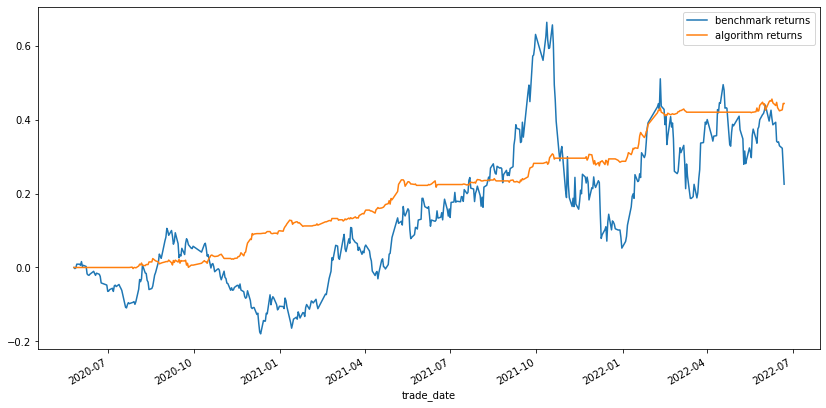

In [35]:
plt.figure(figsize=(14, 7))
metrics.benchmark_cum_returns.plot()
metrics.algorithm_cum_returns.plot()
plt.legend(['benchmark returns', 'algorithm returns'], loc='best')
plt.show()